In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


# קריאת קובץ הנתונים
data = pd.read_csv('data.csv')

# התעלמות מרווחים בתחילת ובסוף שמות העמודות
data.columns = data.columns.str.strip()

# עמודות תזונתיות רלוונטיות
nutritional_columns = ['fructose', 'manganese', 'selenium', 'pantothenic_acid', 'vitamin k','vitamin a re',
                       'total_sugars', 'vitamin d', 'poly_unsaturated_fat', 'mono_unsaturated_fat', 'palmitoleic',
                       'linoleic', 'oleic', 'palmitic', 'lauric', 'saturated fat', 'cholesterol', 'vitamin b12', 'folate',
                       'vitamin b6', 'vitamin b3', 'vitamin c', 'vitamin e', 'vitamin a', 'zinc', 'sodium', 'potassium',
                       'phosphorus', 'magnesium', 'iron', 'calcium', 'total dietary fiber', 'moisture', 'energy', 'carbohydrates',
                       'total_fat', 'protein']

# בדיקה אוטומטית: האם כל העמודות הדרושות קיימות
nutritional_columns = [col for col in nutritional_columns if col in data.columns]

# טיפול בערכים חסרים עם KNN Imputer
if data[nutritional_columns].isna().any().any():#בפעם הראשונה יוצר טבלה עם true/false
    imputer = KNNImputer(n_neighbors=5)        #בפעם השנייה בודק אם לפחו קיימת עמודה אחת עם true
    data[nutritional_columns] = imputer.fit_transform(data[nutritional_columns])#מילוי הערכים החסרים על עדי KNN

# נרמול הנתונים
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[nutritional_columns])

# הוספת עמודת 'product number' לערכים המנורמלים
if 'product number' in data.columns:
    data_scaled_with_number = pd.DataFrame(data_scaled, columns=nutritional_columns)#יצירת דאטה פריים חדש עם הנתונים המנורמלים ועם העמודות המקויות של הדאטה
    data_scaled_with_number['product number'] = data['product number'].values#הוספת הערכים של עמודת פרודקט נמבר לנתונים
else:
    raise ValueError("העמודה 'product number' חסרה בנתונים.")


# בדיקה אם העמודה 'product name' קיימת
if 'product name' in data.columns:
    data_scaled_with_number['product name'] = data['product name'].values

# בדיקה אם העמודה 'product name' קיימת
if 'type' in data.columns:
    data_scaled_with_number['type'] = data['type'].values


# שמירת הנתונים המנורמלים לקובץ CSV
data_scaled_with_number.to_csv('normalized_data.csv', index=False)












In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# קריאת הקובץ
data = pd.read_csv('normalized_data.csv')

# מילון לשמירת מוצרים שנחפשו
searched_products = {}

# ווידוא שהקובץ כולל את הערכים הדרושים
if 'product name' not in data.columns or 'type' not in data.columns:
    raise ValueError("העמודה 'product name' או 'type' חסרות בקובץ הנתונים.")

#חישוב cosine similarity על פי הערכים התזונתיים המנורמלים ולפי עמודת product number
nutritional_columns = [col for col in data.columns if col not in ['product name', 'type']]
cos_sim = cosine_similarity(data[nutritional_columns])

# הוספת מוצר למילון החיפושים
def add_to_searched_products(product_name):
    if product_name not in searched_products:
        searched_products[product_name] = True

# הצגת המוצרים שנחפשו
def get_searched_products():
    return list(searched_products.keys())

# פונקציה למציאת 5 המוצרים הדומים ביותר
def recommend_products(product_name, df, cos_sim):
    if product_name not in df['product name'].values:
        print(f"Error: The product '{product_name}' does not exist in the dataset.")
        return pd.DataFrame()

    # מציאת האינדקס של המוצר המבוקש
    product_index = df[df['product name'] == product_name].index[0]# מציאת המיקום והשם של המוצר בטבלה
    similarities = cos_sim[product_index]#שליפת ערכי הדימיון בין המוצר המבוקש לכל שאר המוצרים

    # יצירת DataFrame עם המוצרים והדמיון
    recommended = df.copy()#יצירת עותק של הנתונים
    recommended['similarity'] = similarities#הוספת עמודת הדימיון להמלצות
    recommended = recommended[recommended.index != product_index].sort_values(by='similarity', ascending=False)
    # מיון ערכי הדימיון מגדול לקטן בלי ערך הדימיון של המוצר שאותו מחפשים במערכת

    # החזרת חמשת המוצרים הדומים ביותר
    return recommended[['product name', 'type', 'similarity']].head(5)

# דוגמת חיפוש של מוצר 1
product_1 = "Bread, white, Angel/Berman/Davidowitz/Eilat"
add_to_searched_products(product_1)
recommended_1 = recommend_products(product_1, data, cos_sim)

print("Recommended products for product 1:")
print(recommended_1)

# דוגמת חיפוש של מוצר 2
product_2 = "Chicken, processed, stars/nuggets"
add_to_searched_products(product_2)
recommended_2 = recommend_products(product_2, data, cos_sim)

print("\nRecommended products for product 2:")
print(recommended_2)

# הצגת רשימת המוצרים שנחפשו
print("\nProducts searched so far:", get_searched_products())


Recommended products for product 1:
                        product name   type  similarity
6           Bread, baguette, Bonjour  bread    0.960901
1              Bread, white, toasted  bread    0.952360
25           Bread, semi-whole wheat  bread    0.937259
34  Wheat flour, white, self-raising  flour    0.931832
10      Bread, challah, Berman/Angel  bread    0.929605

Recommended products for product 2:
                                          product name  type  similarity
670         Chicken, strips with sesame coating, OfTov  food    0.997228
685                           Shnitzel, chicken, OfTov  food    0.997210
668               Chicken, breast/ with sesame, MamaOf  food    0.997048
961                   Chicken, shnitzel/shapes, MamaOf  meat    0.996423
958  Chicken, ground, with added vegetable protein,...  meat    0.992218

Products searched so far: ['Bread, white, Angel/Berman/Davidowitz/Eilat', 'Chicken, processed, stars/nuggets']


In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics_with_accuracy(df, cos_sim):
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_tn = 0
    total_recommendations = 0

    for product_name in df['product name']:
        # מציאת ההמלצות עבור המוצר
        recommended_products = recommend_products(product_name, df, cos_sim)

        # קבלת סוג המוצר המקורי
        product_type = df[df['product name'] == product_name]['type'].values[0]

        # יצירת רשימה של סוגי המוצרים המומלצים
        recommended_types = recommended_products['type'].tolist()

        # חישוב True Positives, False Positives, ו-False Negatives
        for recommended_type in recommended_types:
            total_recommendations += 1 #סך כל ההמלצות
            if recommended_type == product_type:
                total_tp += 1  # מוצר נכון שהומלץ
            else:
                total_fp += 1  # מוצר שגוי שהומלץ

        # חישוב False Negatives
        if product_type not in recommended_types:
            total_fn += 1  # סוג מוצר שלא זוהה

        # חישוב True Negatives (אופציונלי אם יש מוצרים שלא מומלצים בכלל)
        all_product_types = df['type'].unique().tolist()#סוגי המוצרים הייחודיים
        for type in all_product_types:
            if type != product_type and type not in recommended_types:
                total_tn += 1  # מוצר שלא הומלץ

    # חישוב דיוק (Accuracy)
    total_predictions = total_tp + total_fp + total_fn + total_tn
    accuracy = (total_tp + total_tn) / total_predictions if total_predictions > 0 else 0

    # חישוב Precision
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

    # חישוב Recall
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

    # חישוב F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1

# חישוב כל המדדים עבור כל המוצרים
accuracy, precision, recall, f1 = calculate_metrics_with_accuracy(data, cos_sim)




# הדפסת התוצאות
print(f"Accuracy: {accuracy * 100:.2f}%") #היחס בין מספר ההמלצות הנכונות לכלל ההמלצות
print(f"Precision: {precision * 100:.2f}%") ##היחס בין ההמלצות הנכונות (True Positives) לכלל ההמלצות שהמודל סימן כרלוונטיות.(חילוק ב-tp+fp של כל המלצה)
print(f"Recall: {recall * 100:.2f}%") #עד כמה המודל מצליח לזהות את כל המוצרים הרלוונטיים, בלי לפספס.
print(f"F1-Score: {f1 * 100:.2f}%")  # ציון משוקלל שמראה איזון בין הדיוק בזיהוי (Precision) לבין כיסוי מלא של האפשרויות (Recall).


Accuracy: 94.30%
Precision: 75.59%
Recall: 98.51%
F1-Score: 85.54%


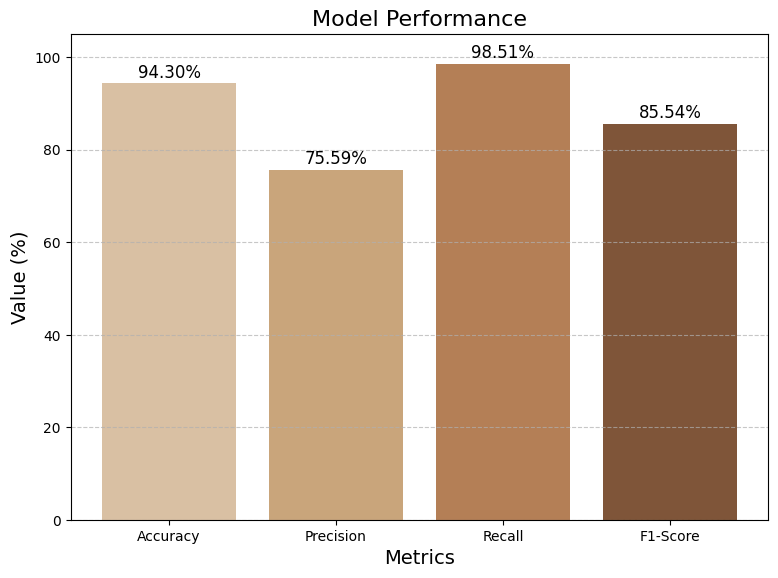

In [4]:
import matplotlib.pyplot as plt

# נתונים עבור המדדים
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [94.30, 75.59, 98.51, 85.54]  # הערכים באחוזים

# יצירת גרף עמודות עם צבעים פסטליים בגווני חום
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['#D9C0A3', '#C9A57B', '#B47F56', '#7F5539'])

# הוספת כותרות וצירים
plt.title('Model Performance', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Value (%)', fontsize=14)

plt.ylim(0, 105)  # הגדלה של גבול הציר העליון ל-105

# הוספת ערכים מעל העמודות
for bar in bars:
    height = bar.get_height()
    # העברת הערך למקום נמוך יותר במקרה של חריגה
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%',
             ha='center', fontsize=12, verticalalignment='bottom')

# הצגת הגרף עם שיפור בגבולות כדי לא לחרוג
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=1.5)  # הקטנת המרווחים
plt.show()
